In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pylibdl.data import DataLoader
from pylibdl.optim import Adam
from utils import DistractedDriver, MyResNet, validate
from pylibdl import cross_entropy_with_logits, mean
from pylibdl.tensor import tensor

In [2]:
path = '/home/superbabes/Downloads/ddriver'
val_data = DistractedDriver(path, val=True)
model = MyResNet.load('model')
model.eval()
for p in model.parameter():
    p.requires_grad = False

In [3]:
print(f'validation accuracy: {validate(model, val_data)*100:.2f}%')

validation accuracy: 91.17%


In [4]:
imgs = [val_data[i*128][0] for i in range(10)]
imgs_tensor = tensor(np.stack(imgs, axis=-1))
imgs = [DistractedDriver.denormalize(i).transpose((1, 2, 0)) for i in imgs]

In [5]:
eps = tensor(np.zeros(imgs_tensor.shape), requires_grad=True)
target = tensor(np.eye(10)[[0] * imgs_tensor.shape[-1]].transpose())
for i in range(5):
    pred = model(imgs_tensor + eps)
    loss = cross_entropy_with_logits(pred, target) + mean(eps**2)
    loss.backward()
    eps.apply_gradient(5)
    eps.zero_grad()
    print(i, loss.numpy(), pred.numpy().argmax(0))

0 4.0769234 [0 1 2 3 4 5 6 7 8 9]
1 0.3699456 [0 0 0 0 0 0 0 0 0 0]
2 0.09164807 [0 0 0 0 0 0 0 0 0 0]
3 0.062581286 [0 0 0 0 0 0 0 0 0 0]
4 0.048369445 [0 0 0 0 0 0 0 0 0 0]


In [6]:
labels = model(imgs_tensor).numpy().argmax(0)
labels_adversarial = model(imgs_tensor + eps).numpy().argmax(0)
imgs_noise = [DistractedDriver.denormalize(eps.numpy()[..., i]).transpose((1, 2, 0)).clip(0, 1) for i in range(len(imgs))]
imgs_adversarial = [DistractedDriver.denormalize((imgs_tensor + eps).numpy()[..., i]).transpose((1, 2, 0)).clip(0, 1) for i in range(len(imgs))]

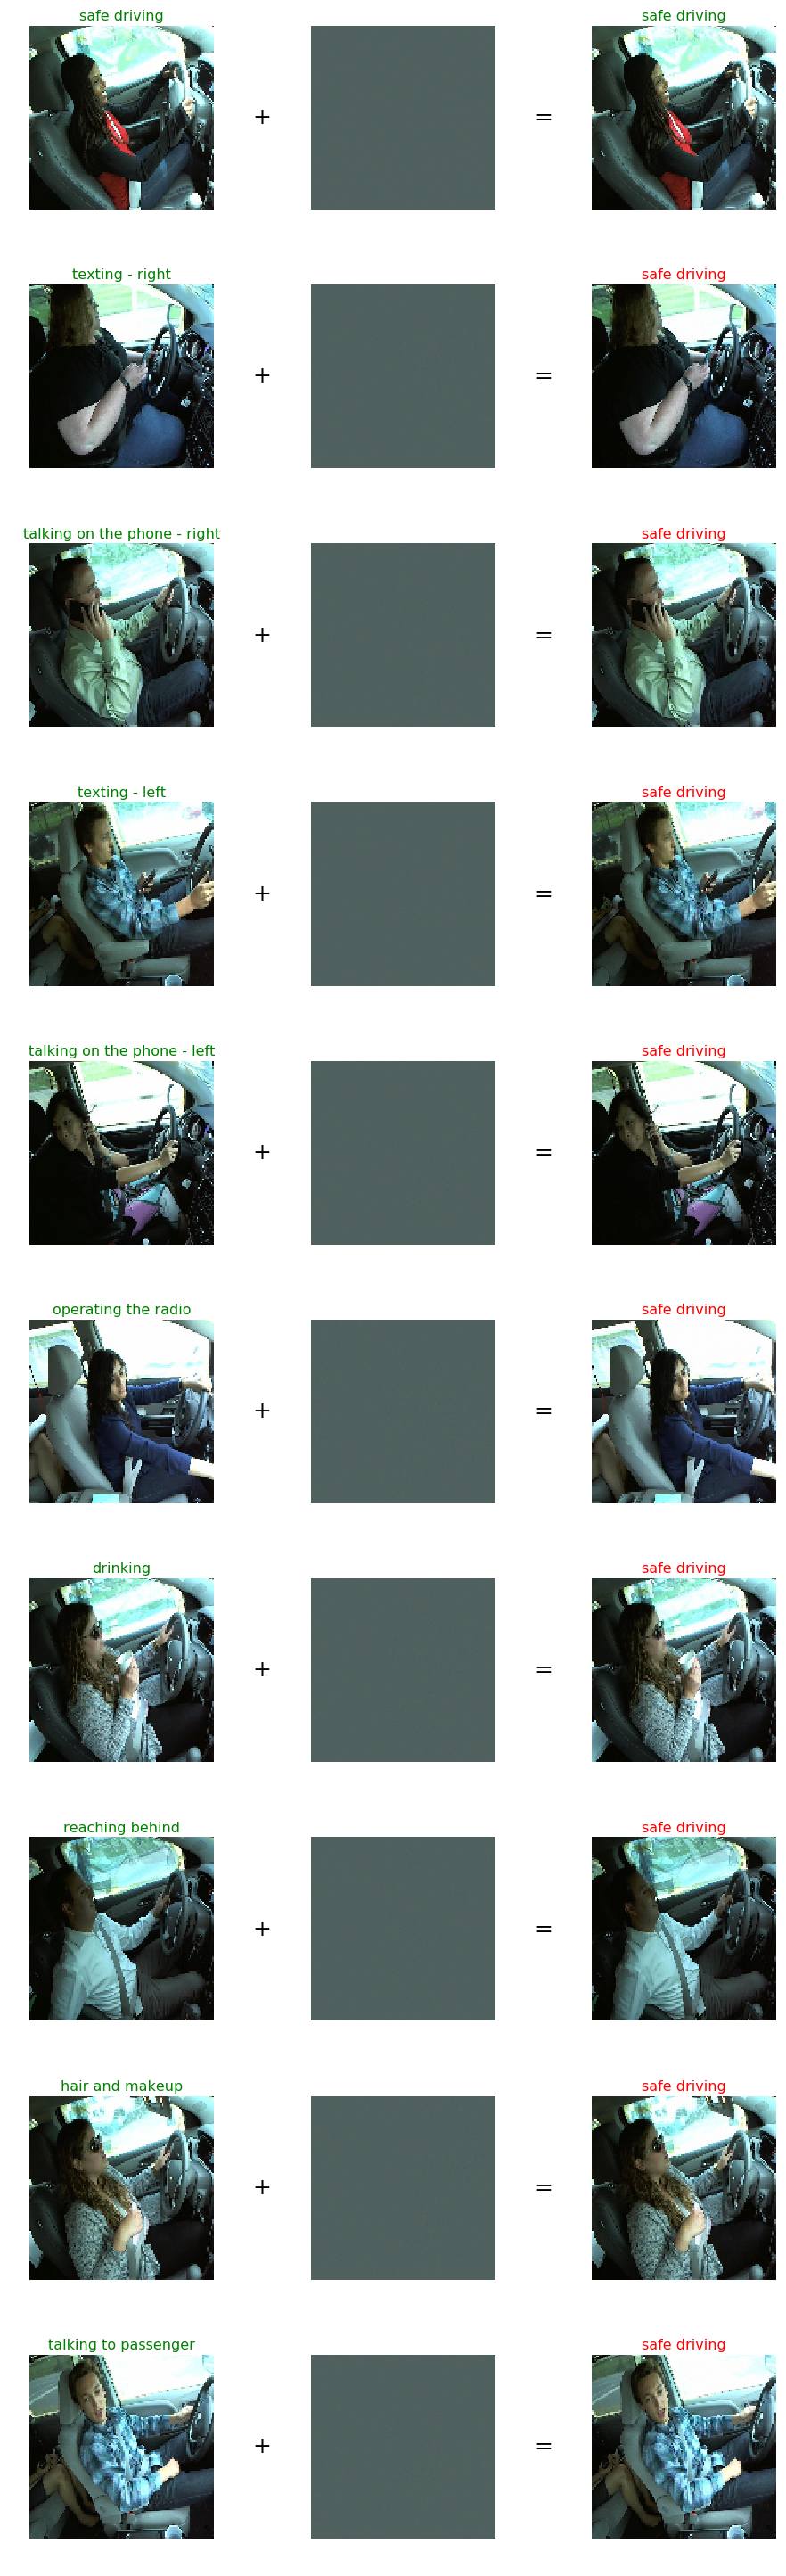

In [7]:
gs = gridspec.GridSpec(10, 5, width_ratios=[1, .25, 1, .25, 1])
plt.figure(figsize=(15, 15*3.5)) 
for i in range(len(imgs)):
    plt.subplot(gs[i, 0])
    plt.axis('off')
    plt.title(DistractedDriver.label_names[labels[i]], color='g' if i == labels[i] else 'r', fontsize=16)
    plt.imshow(imgs[i])
    
    plt.subplot(gs[i, 1])
    plt.axis('off')
    plt.text(.5, .5, '+', horizontalalignment='center', verticalalignment='center', fontsize=25)
    
    plt.subplot(gs[i, 2])
    plt.axis('off')
    plt.imshow(imgs_noise[i])
    
    plt.subplot(gs[i, 3])
    plt.axis('off')
    plt.text(.5, .5, '=', horizontalalignment='center', verticalalignment='center', fontsize=25)
    
    plt.subplot(gs[i, 4])
    plt.axis('off')
    plt.title(DistractedDriver.label_names[labels_adversarial[i]], color='g' if i == labels_adversarial[i] else 'r', fontsize=16)
    plt.imshow(imgs_adversarial[i])